# Random Forests for Spitzer IRAC data reduction
Jessica Krick - IPAC

## Outline
1. Introduction
2. Examine Features
    - Plot Distributions
    - Normalize
3. Train Models
    - Decision Trees
    - Boosted Random Forests
4. Hyperparameter Optimization
5. Additional resources

***

## Introduction
This tutorial is an introduction to python based machine learning using scikit-learn with a real application in astronomy.  We will be using decision trees and boosted random forests to do data reduction on Spitzer IRAC exoplanet light curves.

We would like to generate a model which can remove the instrument generated noise in IRAC light curves thereby allowing us to do high precision photometry and recover exoplanet atmosphere characteristics.  The main  systematic in  high  precision  photometry with IRAC is the intrapixel gain function.   We  see  variations  in  light  curves  due  to the  combination  of  under-sampling  and  small motions of  the telescope.  Unavoidable motions will move  the light around within a single pixel,  and since such a large  fraction  of  the  light  in  the  PSF  falls  in that  single  pixel,  the  total  light  curve  varies by  up  to  8% just due to this effect.  This swamps exoplanet signals by two or more orders of magnitude.  Researchers  have  developed  non-linear  analysis  methods  to  mitigate  this systematic  (Ballard  et  al.  2010;  Stevenson et al. 2012; Fraine et al. 2013; Lewis et al. 2013; Deming et al. 2015; Evans et al. 2015; Morello et al. 2016; Krick et al. 2016).  

Inspired by this work, and the easily available machine learning (ML) tools, we investigate rigorous ML models to best incorporate subject expertise and smart computer techniques with a big calibration dataset.  The goal of this project is to generate a model which uses some features of the calibration dataset to predict intrapixel  gain.   We  can  then  apply  that  model to science datasets to predict gain values which will reduce  the  red  noise in light  curves.   The idea here is that for our calibration dataset, we have measured all of the features we can think of, as well as the flux, for a calibration star where the flux is not changing due to astrophysical sources.  This is known as a labelled  training set, or supervised learning, where the label is the flux, which is the quantity we are trying to predict in our science datasets.  The calibration dataset flux values vary only due to systematics, so if we can  predict that value in the science data, then we can remove it from our light curves, thereby removing the systematics and leaving intact the astrophysical variations, ie.,  the transit/eclipse/phase curve information.

It is important when thinking about ML techniques in astrophysics that we consider how we can use them to reduce our datasets.  This is especially important for uniform reduction of large datasets.

This work is published as Krick et al. 2020 AJ


In [1]:
from platform import python_version

print(python_version())

3.7.5


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import time
import xgboost as xgb
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
#import eli5
#from eli5.sklearn import PermutationImportance
import seaborn as sns
#from pdpbox import pdp


/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Examine Features
Read the csv file into a pandas dataframe and take a quick look at what is there.  If you are not familiar with the pandas package, it is a very powerful, useful, versatile database package that makes data manipulation and visualization relatively easy.  https://pandas.pydata.org

In [3]:
#read in csv file
df = pd.read_csv('../data/pmap_ch2_small.csv')

#display the dataframe
df

,Unnamed: 0,xpos,xerr,ypos,yerr,xycov,flux,fluxerr,np,xfwhm,...,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,edge_mean
0,546516,15.201811,0.001984,15.321713,0.002000,6.327821e-08,0.404620,0.002840,5.907414,2.062314,...,197.393173,330.726532,531.789307,666.198059,4477.075684,2168.426758,412.573090,908.201660,912.660645,18.017332
1,281826,15.167721,0.001987,15.199448,0.001989,3.277485e-08,0.400813,0.002839,4.952903,2.045674,...,219.923492,467.536926,516.239502,679.714966,5294.903809,1438.323730,399.204407,885.784241,853.932007,19.671764
2,268638,15.161523,0.001973,15.121101,0.001971,1.892151e-08,0.403686,0.002804,4.479743,2.049582,...,213.095016,509.479095,518.808838,708.952942,5732.885254,1049.231934,423.162598,908.336243,834.758972,18.780235
3,663080,15.413286,0.002052,15.037270,0.002010,1.555611e-08,0.397416,0.002830,5.499251,2.198105,...,122.417770,288.058289,436.122650,698.697937,4673.622559,539.393921,565.885681,2123.402832,687.879333,21.504503
4,687431,14.909161,0.001995,14.896873,0.001996,9.303351e-09,0.398267,0.002839,5.493610,2.125612,...,457.014648,1590.794312,467.822601,1134.831421,4848.342773,406.598877,351.110596,804.888855,626.879089,19.936926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,730297,14.904481,0.002011,14.853686,0.002014,1.409596e-08,0.396731,0.002793,5.630410,2.094092,...,462.966156,1546.245117,451.222778,1198.041504,4724.530762,386.285828,386.255371,791.103149,617.431763,17.029633
49996,407233,15.362074,0.002026,15.179676,0.002001,6.460910e-08,0.400351,0.002824,5.713924,2.184343,...,137.699738,249.908630,488.341522,636.505859,4678.210449,1068.312012,494.009003,1729.306396,866.502686,22.756880
49997,588547,14.794768,0.002038,14.825884,0.002035,3.672593e-08,0.394605,0.002803,6.803192,2.142609,...,699.997131,2249.018799,417.903656,1200.286377,3763.123779,392.790100,362.768097,825.088135,483.583923,16.260239
49998,122127,15.221736,0.001994,14.962264,0.001982,-8.216773e-09,0.399166,0.002832,4.486208,2.116484,...,177.168869,470.960388,479.798981,980.606140,5683.546875,435.691925,485.980896,1136.298340,714.768372,20.615129


In [4]:
#list out all of the column names so we know what we are dealing with
list(df.columns)

['Unnamed: 0',
 'xpos',
 'xerr',
 'ypos',
 'yerr',
 'xycov',
 'flux',
 'fluxerr',
 'np',
 'xfwhm',
 'yfwhm',
 'dn_peak',
 'bmjd',
 't_cernox',
 'bg_flux',
 'sigma_bg_flux',
 'pix1',
 'pix2',
 'pix3',
 'pix4',
 'pix5',
 'pix6',
 'pix7',
 'pix8',
 'pix9',
 'edge_mean']

In [5]:
#look at statistics of a particular column (flux)
df.flux.describe()

count    50000.000000
mean         0.400587
std          0.002568
min          0.389770
25%          0.398999
50%          0.400858
75%          0.402385
max          0.475674
Name: flux, dtype: float64

### Plot Distributions
Now we want to look at the data a bit to make sure we know what we have.  Here I plot the distributions of each feature.  Because I am going to be plotting histograms, I do a bit of cleaning up first.  I first make a dataframe which has outliers removed from it by only keeping those values in each column that are within 3sigma of the mean in that column. Then I remove NAN's.  Finally I set up the structure for a large plot, and fill each panel with a histogram.

Text(0.5, 1.0, 'pix9')

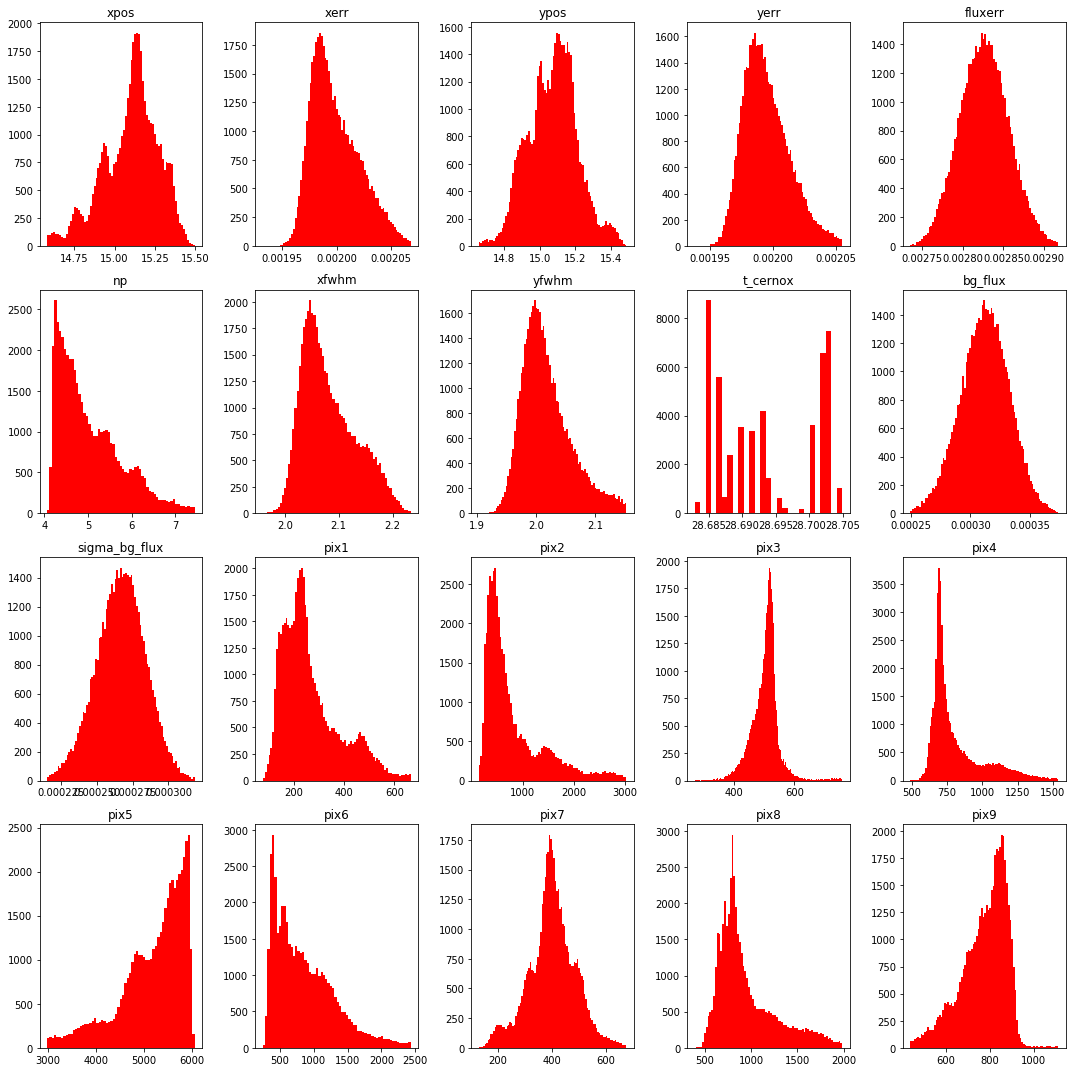

In [6]:
#remove outliers
df_sigclip = df[np.abs(df - df.mean()) <= (3 * df.std())]

xpos = df_sigclip['xpos']
xerr = df_sigclip['xerr']
ypos = df_sigclip['ypos']
yerr = df_sigclip['yerr']
flux = df_sigclip['flux']
fluxerr = df_sigclip['fluxerr']
np = df_sigclip['np']
xfwhm = df_sigclip['xfwhm']
yfwhm = df_sigclip['yfwhm']
t_cernox = df_sigclip['t_cernox']
bg_flux = df_sigclip['bg_flux']
sigma_bg_flux = df_sigclip['sigma_bg_flux']
pix1 = df_sigclip['pix1']
pix2 = df_sigclip['pix2']
pix3 = df_sigclip['pix3']
pix4 = df_sigclip['pix4']
pix5 = df_sigclip['pix5']
pix6 = df_sigclip['pix6']
pix7 = df_sigclip['pix7']
pix8 = df_sigclip['pix8']
pix9 = df_sigclip['pix9']

#remove NANs
xpos.dropna(inplace=True)
xerr.dropna(inplace=True)
ypos.dropna(inplace=True)
yerr.dropna(inplace=True)
flux.dropna(inplace=True)
fluxerr.dropna(inplace=True)
np.dropna(inplace=True)
xfwhm.dropna(inplace=True)
yfwhm.dropna(inplace=True)
t_cernox.dropna(inplace=True)
bg_flux.dropna(inplace=True)
sigma_bg_flux.dropna(inplace=True)
pix1.dropna(inplace=True)
pix2.dropna(inplace=True)
pix3.dropna(inplace=True)
pix4.dropna(inplace=True)
pix5.dropna(inplace=True)
pix6.dropna(inplace=True)
pix7.dropna(inplace=True)
pix8.dropna(inplace=True)
pix9.dropna(inplace=True)



#setup plots
n_bins = 20
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,15), sharey = False, tight_layout = True)
fig.subplots_adjust(wspace = 0)
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19 = axes.flatten()

ax0.hist(xpos, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax0.set_title('xpos')

ax1.hist(xerr, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax1.set_title('xerr')

ax2.hist(ypos, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax2.set_title('ypos')

ax3.hist(yerr, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax3.set_title('yerr')

ax4.hist(fluxerr, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax4.set_title('fluxerr')

ax5.hist(np, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax5.set_title('np')

ax6.hist(xfwhm, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax6.set_title('xfwhm')

ax7.hist(yfwhm, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax7.set_title('yfwhm')

ax8.hist(t_cernox, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax8.set_title('t_cernox')

ax9.hist(bg_flux, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax9.set_title('bg_flux')

ax10.hist(sigma_bg_flux, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax10.set_title('sigma_bg_flux')

ax11.hist(pix1, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax11.set_title('pix1')

ax12.hist(pix2, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax12.set_title('pix2')

ax13.hist(pix3, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax13.set_title('pix3')

ax14.hist(pix4, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax14.set_title('pix4')

ax15.hist(pix5, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax15.set_title('pix5')

ax16.hist(pix6, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax16.set_title('pix6')

ax17.hist(pix7, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax17.set_title('pix7')

ax18.hist(pix8, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax18.set_title('pix8')

ax19.hist(pix9, bins = 'fd',  histtype = 'barstacked', color = 'red')
ax19.set_title('pix9')

#  If you want to save this figure, uncomment here
#savename = 'pmap_dist.png'
#plt.savefig(savename)



### Normalize
We need to do some normalization because the star that is used here to make the training dataset will not have the same brightness as whatever science targets people will be using.  Here people often use scalers which are built in functions in scikit-learn to automatically scale the data in some way, and then save that scaling to be applied to the science dataset.

In [7]:
#adjust the pixel values to be normalized by the mean of the sum of all pixel values
#first make a column called 'pixsum' which is the sum of all 9 pixel values
#then determine the mean over the entire pixsum column - so this is sort
# of like the mean total flux over all observations

df['pixsum'] = df['pix1'] + df['pix2'] + df['pix3'] + df['pix4'] + df['pix5'] + df['pix6']+df['pix7'] + df['pix8']+ df['pix9']
meanflux = statistics.mean(df['pixsum'])

#normalize using that mean total flux value
df['pix1']/= meanflux
df['pix2']/= meanflux
df['pix3']/= meanflux
df['pix4']/= meanflux
df['pix5']/= meanflux
df['pix6']/= meanflux
df['pix7']/= meanflux
df['pix8']/= meanflux
df['pix9']/= meanflux

#normalize bg_flux, flux uncertainty, and background uncertainty by their respective means as well
meanbgflux = statistics.mean(df['bg_flux'])
meanfluxerr=statistics.mean(df['fluxerr'])
meansigmabgflux = statistics.mean(df['sigma_bg_flux'])

df['bg_flux'] /= meanbgflux
df['fluxerr']/= meanfluxerr
df['sigma_bg_flux'] /= meansigmabgflux

#normalize flux
y = df['flux']
my = statistics.median(y)
norm_y = y / my




## Train Models
Through either domain knowledge or examination of the plot of feature distributions, or some other test, choose a set of features to use to train the models.  In this example, we stick with a very small set of features which I think to be important for reducing IRAC data.  Then we take the very important step of saving out some data for testing later, so that it is not part of the training process.  We use a train/test split of 75/25 which means that we train the algorithms on 75% of the calibration data, saving 25% on which the models have not been able to train, allowing us to evaluate performance.  These test sets are randomly chosen from the calibration data.

In [8]:
#choose feature set just for testing
#X = df[['xpos','ypos','xfwhm','yfwhm','pix5']]
X = df[['xpos','ypos','xfwhm','yfwhm','pix5']]
#divide into traning and test datasets
#setting a random state will allow for the exact same split every time this is run
X_train, X_test, y_train, y_test = train_test_split(X, norm_y, random_state = 123, test_size = 0.25)



### Decision Tree

How do we know which ML models to use when just starting out?  Our stated problem is a regression problem, not a classification problem, so that sends us towards a family of models suited for regressions.  To me decision trees are easy (or easier) to conceptualize than some of the other tools.  

As a first step, we use our labeled dataset on our calibration target to build a single, basic decision tree with the above listed features, and then use that tree to predict what the flux will be of unseen science data.  Decision trees are most commonly thought of in terms of 1D classification where the outcome is to classify an object based on it's features. A 1D regression based on a decision tree looks like a linear approximation to the regression function.  This gets extrapolated to a multi-dimensional space of features. 

The key to the machine learning aspect of decision trees is that the machine decides how to split up the feature space at each node of the tree to minimize a cost criterion.  There is no human intervention in deciding how to split the features.  The metric used to determine when and how to split each branch into subsequent branches is mean squared error (MSE). MSE is the average of the squares of the deviations between observed and predicted values. Values closer to zero are better as they indicate lower deviations of the predicted values from their true values.  

A decision tree has a few parameters over which the user has control, called hyperparameters: the number of levels in the tree (how deep the tree is) and how many leaves are allowed on each branch are two hyperparameters we set manually.  

We use R^2 to evaluate the performance of our models.  There are many statistical metrics that could be used, we show also MSE and MAE.  R^2 should give us an idea of how well the predictions fit the data where an R^2 of 1 indicates a perfect fit.  


In [9]:
# Fit a decision tree regression model

t1 =time.time()
max_depth = 20  #how many levels is the tree allowed to have
min_leaves = 32  #the branch will not split if less than this number are left in each resulting node

#setup the model then fit it (do the training)
regr_DT = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_leaves)
regr_DT.fit(X_train, y_train)

#predict values for test dataset that was not included in training
y_predict_DT_test = regr_DT.predict(X_test)
y_predict_DT_train = regr_DT.predict(X_train)


#save the model
#joblib.dump(regr_DT, 'DT_tutorial.pkl')

#report accuracies
print("r2_score (DT test): {:.2f}".format(r2_score(y_test, y_predict_DT_test)))
print("r2_score (DT train): {:.2f}".format(r2_score(y_train, y_predict_DT_train)))
print("Mean squared error (DT): {:.8f}".format(mean_squared_error(y_test, y_predict_DT_test)))
print("Median absolute error (DT): {:.8f}".format(median_absolute_error(y_test, y_predict_DT_test)))

t2 = time.time()
print('total time elapsed for fitting DT', t2 - t1)

r2_score (DT test): 0.62
r2_score (DT train): 0.69
Mean squared error (DT): 0.00001485
Median absolute error (DT): 0.00252739
total time elapsed for fitting DT 0.24700427055358887


### Boosted Random Forest
An ensemble of decision trees is a random forest. In the case of a random regression forest, many trees are fit and the mean of the output for each input set is used as the final value.  There are two things that make each tree in the forest different from other trees which gives rise to the "random" on the name of this method. Each tree is built from a random subset of the data, and at each decision node in the tree, a random subset of the features are considered in splitting the data.  Therefore each tree is slightly different, and the forest ensemble averages, hopefully, to a better overall regression fit.  

The advantage of a forest of random trees is that it minimizes over-fitting since each tree only sees a random subset of the data with a random subset of features at each node. Random Forest models using scikit-learn's 'randomforestregressor' are slow to run.

Boosting is a way of weighting the input values to the trees such that those values which are not as well fit are given higher weight in future trees.  In this way, as more trees are added to the forest, the trees hopefully get "smarter".  We use XGBoost for this work because it is faster than than scikit-learn's GradientBoostingRegressor.  

Here the new hyperparameters that I set manually are the number of trees and a learning rate.  The number of trees can easily be in the thousands, but for speed of the tutorial, we set at a modest 100.  Learning rate is a way of slowing down the boosting that occurs with every new additional tree to prevent overfitting.

In [10]:
#now xgboost
t1 =time.time()
n_trees  = 100
max_depth = 10
learning_rate =0.01

xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth,eta= learning_rate)
xgbr.fit(X_train, y_train)

#predict values for test dataset that was not included in training
y_predict_xgbr = xgbr.predict(X_test)

#save the model
#joblib.dump(xgbr, 'xgbr_tutorial.pkl')

#report accuracies
print("r2_score (XGBoost test): {:.2f}".format(r2_score(y_test, y_predict_xgbr)))
print("Mean squared error (XGBoost): {:.8f}".format(mean_squared_error(y_test, y_predict_xgbr)))
print("Median Absolute error (XGBoost): {:.8f}".format(median_absolute_error(y_test, y_predict_xgbr)))

t2 = time.time()
print('total time elapsed for fitting XGBoost', t2 - t1)

[17:44:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


r2_score (XGBoost test): 0.64
Mean squared error (XGBoost): 0.00001445
Median Absolute error (XGBoost): 0.00239697
total time elapsed for fitting XGBoost 5.647963047027588


### Hyperparameter Optimization

Hyperparameters are parameters which are not used in the learning process itself, but which control the capacity of the model.  As discussed above, an example of a hyperparameter is the depth of the decision tree. Hyperparameters must be set before training the tree, and should be set properly to prevent overfitting, which is common in machine learning.  Sure, a very large number of branches might accurately reflect the training data, but would not be good at predicting values on data unseen.  The most common way to do hyperparameter optimization is to perform a grid search over all reasonable hyperparameter values, choosing the hyperparameter set which optimizes some metric. A full grid search is computationally very expensive, and we therefore employ a randomized grid search (Bergstra & Bengio, 2012), where we randomly sample the hyperparameter space and assume we have tested enough locations to be close enough to the true minimum.

A further important detail in our hyperparameter optimization is that we use k-fold cross validation (CV).  At each random position in our hyperparameter space, instead of the machine learning a single forest on the training dataset, the training dataset is split into K different sections (folds). Then one fold is held out for the test dataset and a model is learned on the remaining K-1 folds.  This proceeds K-1 times, with each of the folds being held out as a test set once, and the remaining folds combined as the training set.  At the end of running all the folds, the average is taken of the accuracy of each fold to represent the overall accuracy of that position in hyperparameter space.  This technique of evaluating the model more than once at each position helps to estimate the predictive power that our model will have once it is used on real data while simultaneously limiting overfitting by holding out different portions of the dataset each time.  Note, this K-fold CV does not ever touch the "real" test data, so that at the end of our hyperparameter search, when we have discovered the ideal hyperparameters, we can then re-learn a model on the entire training dataset, and evaluate it on the test dataset, and the test dataset will not ever have been used in the learning process. 

In [11]:

t1 = time.time()

#set up XGBoost 
max_depth = 10
n_trees = 10
learning_rate = 0.01
xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth, eta= learning_rate) 


#choose a set of parameters over which to do the hyperparameter search
xgbr_params_dist = { 'max_depth': sp_randint(3, 12),
          'n_estimators': sp_randint(10, 100), #10000
           'eta':[ 0.1, 0.05, 0.02, 0.01, 0.005, 0.002] }


#set up the random search
rand_xgbr = RandomizedSearchCV(xgbr, param_distributions = xgbr_params_dist, n_iter = 10, cv=5, 
                                n_jobs = -1, verbose = 10 )
#run the random search
rand_xgbr.fit(X_train, y_train)

print("Best xgbr parameters set:")
print(rand_xgbr.best_estimator_)

#predict values for test dataset that was not included in training
y_predict_rand = rand_xgbr.predict(X_test)

#save the model
#joblib.dump(rand_xGBR, 'xgboost_search_ch2.pkl')

#report accuracies
print("r2_score (XGBoost test): {:.2f}".format(r2_score(y_test, y_predict_rand)))
print("Mean squared error (XGBoost): {:.8f}".format(mean_squared_error(y_test, y_predict_rand)))
print("Median Absolute error (XGBoost): {:.8f}".format(median_absolute_error(y_test, y_predict_rand)))


t2 = time.time()
print('total time elapsed for random search xgbr', t2-t1)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.9s finished
/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:45:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best xgbr parameters set:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.002, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=96,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
r2_score (XGBoost test): 0.64
Mean squared error (XGBoost): 0.00001444
Median Absolute error (XGBoost): 0.00239073
total time elapsed for random search xgbr 39.80282211303711


### Real World Test
An important step not included here in the interest of time is to test this final model on a dataset which is not the calibration dataset to make sure the model is achieving good systematics reductions.  This would be any light curve from the Spitzer IRAC light curve, where the features are measured in the same way, and scaled in the same way as the calibration dataset above.

### More Resources
http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html
 
https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608

https://towardsdatascience.com/introducing-pdpbox-2aa820afd312

https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.explain_prediction

https://github.com/oracle/Skater/blob/master/examples/xgboost_regression_example.ipynb

https://github.com/marcotcr/lime

https://shap.readthedocs.io/en/latest/